# Table of Contents
1. [Introduction](#introduction)
    - Objective
    - Dataset Overview
2. [Data Loading](#data-loading)
    - Import Libraries
    - Load Data
    - Data Structure Overview
3. [Data Cleaning and Preprocessing](#data-cleaning-and-preprocessing)
    - Drop Unnecessary Columns
    - Handle Missing Values
    - Data Type Conversion
    
4. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
    - Statistical Summary
    - Visualization
    - Correlation Analysis
5. [Feature Engineering](#feature-engineering)
    - Textual Features
    - Time-based Features
    - Categorical Encoding
    - Derived Statistical Features (Text Statistics)
6. [Model Preparation](#model-preparation)
    - Data Splitting
    - Feature Selection
7. [Predictive Modeling](#predictive-modeling)
    - Baseline Model
    - Model Building and Tuning
    - Model Evaluation
8. [Insights and Conclusion](#insights-and-conclusion)
    - Summary of Findings
    - Recommendations
    - Limitations and Future Work


# 1. Introduction

## Objective
The primary goal of this analysis is to understand the characteristics of successful posts on the subreddit r/askscience. By identifying the attributes that contribute to the popularity and engagement of posts, measured by their scores and upvote ratios, we aim to uncover insights that could guide users in crafting content that resonates with the community.

## Dataset Overview
This dataset comprises a collection of posts from the r/askscience subreddit, which is renowned for its scientific discussions and expert contributions. The dataset includes several key features for each post:

- `title`: The title of the post.
- `body`: The main text content of the post.
- `tag`: The category or field of science the post pertains to.
- `datetime`: The date and time the post was submitted.
- `author`: The username of the post's creator.
- `score`: The net number of upvotes minus downvotes the post has received. A higher score indicates that a post has received more upvotes than downvotes, reflecting overall community approval.
- `upvote_ratio`: The ratio of upvotes to the total number of votes (upvotes plus downvotes). This ratio, expressed as a percentage, shows the proportion of viewers who liked the post. A higher upvote ratio indicates a higher consensus among voters in favor of the post.
- `url`: The direct link to the Reddit post. This URL can be used to access the post directly and may play a role in how the post is shared and viewed externally, potentially affecting its visibility and popularity.

The primary focus of this analysis is twofold. First, we aim to identify the key attributes that contribute to the success of posts on r/askscience, utilizing a comprehensive examination of features such as post content, timing, and category tags. Success will be quantified primarily through `score` and `upvote_ratio`, which serve as our labels for measuring overall popularity and community approval, respectively.

Second, we will build a predictive model that estimates the score of a post based on a combination of available features, including but not limited to the title and body of the post. This model will help us understand which characteristics are most predictive of a post's success, and it will involve an exploration of various features to ascertain their relevance and influence. The choice of features will be systematically justified to ensure that each contributes meaningfully to our understanding and prediction of post success.

In doing so, this analysis will not only highlight the factors that are most influential in garnering positive engagement on the subreddit but also provide actionable insights that could assist content creators in optimizing their submissions to r/askscience.


---
# 2. Data Loading

In this section, we will import necessary Python libraries required for our data analysis and subsequently load the dataset into a pandas DataFrame. This will allow us to work with the data effectively in the subsequent sections of this notebook.


In [23]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# For Topic Modelling
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# For Vector Embedding
import spacy
import re
import typing_extensions

# For Categorical Encoding
from sklearn.preprocessing import OneHotEncoder


# For Sentiment Analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
# Load the SpaCy model
nlp = spacy.load('en_core_web_lg')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Settings to suppress warnings
warnings.filterwarnings('ignore')

# Settings for matplotlib to ensure our charts are displayed within the notebook
%matplotlib inline

# Setting the style for seaborn plots
sns.set(style="whitegrid")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ahmadhashemi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Load the dataset
data_path = './askscience_data.csv'
reddit_df = pd.read_csv(data_path)

# Display the first few rows of the dataset to confirm it's loaded correctly
reddit_df.head()

,Unnamed: 0,title,body,tag,datetime,author,score,upvote_ratio,url
0,0,Post viral cough: why does it get worse after ...,Tl;dr: why is your cough during an upper respi...,Human Body,2022-12-09 02:52:07,CarboniferousCreek,1343.0,0.93,https://www.reddit.com/r/askscience/comments/z...
1,1,Can an x-ray of an adult show chronic malnouri...,If a person was chronically undernourished thr...,Human Body,2022-12-08 18:28:51,Foxs-In-A-Trenchcoat,426.0,0.91,https://www.reddit.com/r/askscience/comments/z...
2,2,[META] Bots and AI tools on r/askscience,\n\nOver the past few days we have seen a sur...,META,2022-12-08 09:04:25,AskScienceModerator,2218.0,0.92,https://www.reddit.com/r/askscience/comments/z...
3,3,Can you predictably manipulate a magnetic gas?,Does there exist a gas that changes in respons...,Physics,2022-12-08 20:01:53,hufsa7,48.0,0.83,https://www.reddit.com/r/askscience/comments/z...
4,4,Are there cells in humans (or other mammals) t...,NaN,Medicine,2022-12-09 01:11:34,Velym,14.0,0.89,https://www.reddit.com/r/askscience/comments/z...


## Data Structure Overview

<Axes: >

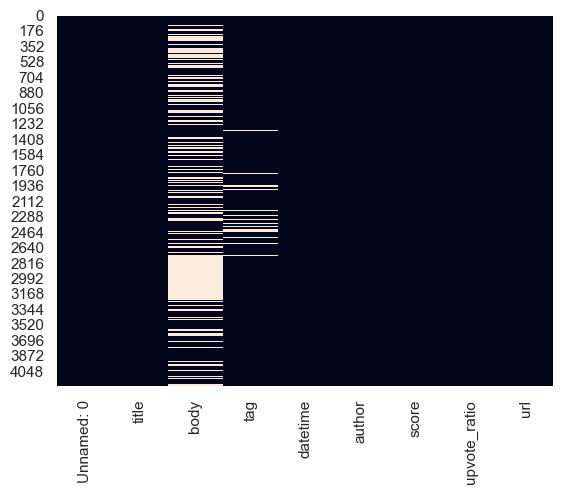

In [3]:
# To plot missing data
sns.heatmap(reddit_df.isna(), cbar=False)

In [4]:
# The ratio of missing values in each column
reddit_df.isna().sum()/len(reddit_df)

Unnamed: 0      0.000000
title           0.000000
body            0.407372
tag             0.046136
datetime        0.000000
author          0.000000
score           0.000000
upvote_ratio    0.000000
url             0.000000
dtype: float64

In [5]:
# Checking the structure of the dataset
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4205 entries, 0 to 4204
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    4205 non-null   int64  
 1   title         4205 non-null   object 
 2   body          2492 non-null   object 
 3   tag           4011 non-null   object 
 4   datetime      4205 non-null   object 
 5   author        4205 non-null   object 
 6   score         4205 non-null   float64
 7   upvote_ratio  4205 non-null   float64
 8   url           4205 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 295.8+ KB



- **Entries and Columns:** The dataset consists of 4,205 entries and 9 columns.
- **Columns Overview:**
  - `Unnamed: 0`: Index column, to be removed as it contains redundant data.
  - `title`, `body`, `tag`, `datetime`, `author`, `url`: Textual data, with `body` and `tag` showing some missing entries.
  - `score`, `upvote_ratio`: Numeric values representing post popularity metrics.
- **Data Types:** Mixed types with integers, floats, and objects (strings).
- **Missing Data:** Notable in `body` (2,492 non-null) and `tag` (4,011 non-null).
- **Memory Usage:** About 295.8 KB.

Immediate next steps include removing unnecessary columns and addressing missing values, particularly in `body` and `tag`, and converting `datetime` to a datetime format for further analysis.

---
# 3. Data Cleaning and Preprocessing

Before we dive into exploratory data analysis and modeling, it's crucial to clean and preprocess our data. This includes removing unnecessary columns, handling missing values, and converting data types to ensure accurate analysis. Here are the steps we'll take:

## Dropping Unnecessary Columns

The dataset contains an 'Unnamed: 0' column, which appears to be a redundant index and does not provide useful information for our analysis. We will remove this column from both versions of our dataset to clean up our data.

```python
# Creating two copies of the DataFrame for different preprocessing strategies
reddit_df_retain = reddit_df.copy()
reddit_df_with_body = reddit_df.copy()

# Dropping the 'Unnamed: 0' column in both DataFrames
reddit_df_retain.drop('Unnamed: 0', axis=1, inplace=True)
reddit_df_with_body.drop('Unnamed: 0', axis=1, inplace=True)
```

## Handling Missing Values

Properly addressing missing values is crucial for ensuring the integrity and accuracy of our analysis. The columns `body` and `tag` have missing entries, each requiring a specific approach:

### Handling Missing `body` Data
Given the importance of the `body` text for detailed text analysis and the value of the `title` for posts that might convey complete messages on their own, we will adopt a dual strategy:

1. **Retain and Modify for Textual Analysis:**
   - For textual analysis where detailed text is not mandatory (like sentiment analysis where titles might suffice or be indicative of sentiment), we will retain these rows. Missing `body` texts will be handled as follows:
     - **Conditional Feature Engineering:** Adjust text-based features to account for missing `body` text, such as setting character counts to 0 for missing entries.
       ```python
       # Applying conditional feature engineering for missing 'body'
       reddit_df_retain['body_length'] = reddit_df_retain['body'].apply(lambda x: len(x) if pd.notnull(x) else 0)
       ```
       
     - **Binary Indicator for Missing Data:** Implement a binary indicator to denote missing `body` data, providing context that can be crucial for certain models.
       ```python
       # Creating a binary indicator for missing 'body' data
       reddit_df_retain['body_missing'] = reddit_df_retain['body'].isna().astype(int)
       reddit_df_retain['body'].fillna('', inplace=True)  # Replace NaN with empty string after creating indicators
       ```


2. **Remove for In-Depth Textual Analysis:**
   - For in-depth analysis that requires complete text data (such as detailed NLP tasks focusing on `body` content), we will remove rows with missing `body` data to maintain data quality.
     ```python
     # Removing rows where 'body' is missing for specific analyses
    reddit_df_with_body = reddit_df_with_body.dropna(subset=['body'])
    reddit_df_with_body['body_length'] = reddit_df_with_body['body'].apply(lambda x: len(x))
     ```

### Handling Missing `tag` Data
For missing categorical data in the `tag` column, we will assign a default label of 'Untagged' to both datasets::

```python
# Filling missing 'tag' entries with 'Untagged' in both DataFrames
reddit_df_retain['tag'].fillna('Untagged', inplace=True)
reddit_df_with_body['tag'].fillna('Untagged', inplace=True)
```

## Data Type Conversion

The 'datetime' column is currently stored as an object type (string), which is not ideal for time-series analysis or extracting date-based features. We'll convert this column to the datetime type.

```python
# Converting 'datetime' from string to datetime format for both DataFrames
reddit_df_retain['datetime'] = pd.to_datetime(reddit_df_retain['datetime'])
reddit_df_with_body['datetime'] = pd.to_datetime(reddit_df_with_body['datetime'])
```

With these preprocessing steps complete, our datasets are now clean and properly formatted for the next phases of our project, which include exploratory data analysis and building predictive models.

In [6]:
# Create two copies of the DataFrame for different preprocessing strategies
reddit_df_retain = reddit_df.copy()
reddit_df_with_body = reddit_df.copy()


# Dropping the 'Unnamed: 0' column in both DataFrames
reddit_df_retain.drop('Unnamed: 0', axis=1, inplace=True)
reddit_df_with_body.drop('Unnamed: 0', axis=1, inplace=True)


# Handling Missing 'body' Data
# * Retain and Modify for Textual Analysis:
# Applying conditional feature engineering for missing 'body'
reddit_df_retain['body_length'] = reddit_df_retain['body'].apply(lambda x: len(x) if pd.notnull(x) else 0)

# Creating a binary indicator for missing 'body' data
reddit_df_retain['body_missing'] = reddit_df_retain['body'].isna().astype(int)
reddit_df_retain['body'].fillna('', inplace=True)  # Replace NaN with empty string after creating indicators

# * Remove for In-Depth Textual Analysis:
# Removing rows where 'body' is missing for specific analyses
reddit_df_with_body = reddit_df_with_body.dropna(subset=['body'])
reddit_df_with_body['body_length'] = reddit_df_with_body['body'].apply(lambda x: len(x))


# Handling Missing 'tag' Data
# Filling missing 'tag' entries with 'Untagged' in both DataFrames
reddit_df_retain['tag'].fillna('Untagged', inplace=True)
reddit_df_with_body['tag'].fillna('Untagged', inplace=True)


# Converting 'datetime' from string to datetime format for both DataFrames
reddit_df_retain['datetime'] = pd.to_datetime(reddit_df_retain['datetime'])
reddit_df_with_body['datetime'] = pd.to_datetime(reddit_df_with_body['datetime'])

---
# 4. Exploratory Data Analysis (EDA)

Exploratory Data Analysis is essential to uncover underlying patterns, identify anomalies, and understand the distribution of the data in our dataset. We will perform this analysis separately for each preprocessed dataset: `reddit_df_retain` (where missing `body` data is retained) and `reddit_df_with_body` (where missing `body` data is removed). This will help us understand the impact of these preprocessing decisions on the data's characteristics.


## Statistical Summary

In [7]:
from IPython.display import display_html

# Get descriptive statistics for both datasets
describe_retain = reddit_df_retain[['score', 'upvote_ratio', 'body_length']].describe()
describe_with_body = reddit_df_with_body[['score', 'upvote_ratio', 'body_length']].describe()

# Convert the descriptive statistics DataFrames to HTML
retain_html = describe_retain.style.set_table_attributes("style='display:inline'").set_caption('All Posts')._repr_html_()
with_body_html = describe_with_body.style.set_table_attributes("style='display:inline'").set_caption('Posts with Body')._repr_html_()

# Display them side by side by concatenating the HTML code
display_html(retain_html + '&nbsp;&nbsp;&nbsp;&nbsp;' + with_body_html, raw=True)

,score,upvote_ratio,body_length
count,4205.000000,4205.000000,4205.000000
mean,3730.471106,0.765719,243.058264
std,5577.606541,0.177537,406.931267
min,0.000000,0.170000,0.000000
25%,4.000000,0.590000,0.000000
50%,35.000000,0.840000,114.000000
75%,7472.000000,0.920000,337.000000
max,83382.000000,1.000000,5134.000000
,score,upvote_ratio,body_length
count,2492.000000,2492.000000,2492.000000


### Preliminary Statistical Insights:

#### Score Insights:
- **Mean Scores**: The mean scores across all posts are higher (3730.47) than for posts specifically with body text (2177.40). This could indicate that while posts with body text are expected to engage users more deeply, the highest scoring posts may not always include detailed content.
- **Variability**: The range of scores in both datasets highlights significant variability. However, posts with body text do not always guarantee higher scores, as evidenced by the overall higher mean in the complete dataset.

#### Upvote Ratio Insights:
- **Average Upvote Ratios**: The average upvote ratios are very similar across both datasets, with posts with body text showing a marginally lower average (0.73) compared to the overall (0.77). This suggests that having body text does not significantly correlate with a higher rate of positive reception.
- **Distribution of Upvote Ratios**: The similarity in upvote ratios might suggest that the presence of body text does not dramatically affect how posts are received, contrary to what might be expected.


## Visualization

### Histograms of Scores and Upvote Ratios

To facilitate a clear comparison, we will create side-by-side histograms with Kernel Density Estimates (KDE) for each dataset. These plots will show us the distribution of `score` and `upvote_ratio` across both datasets.

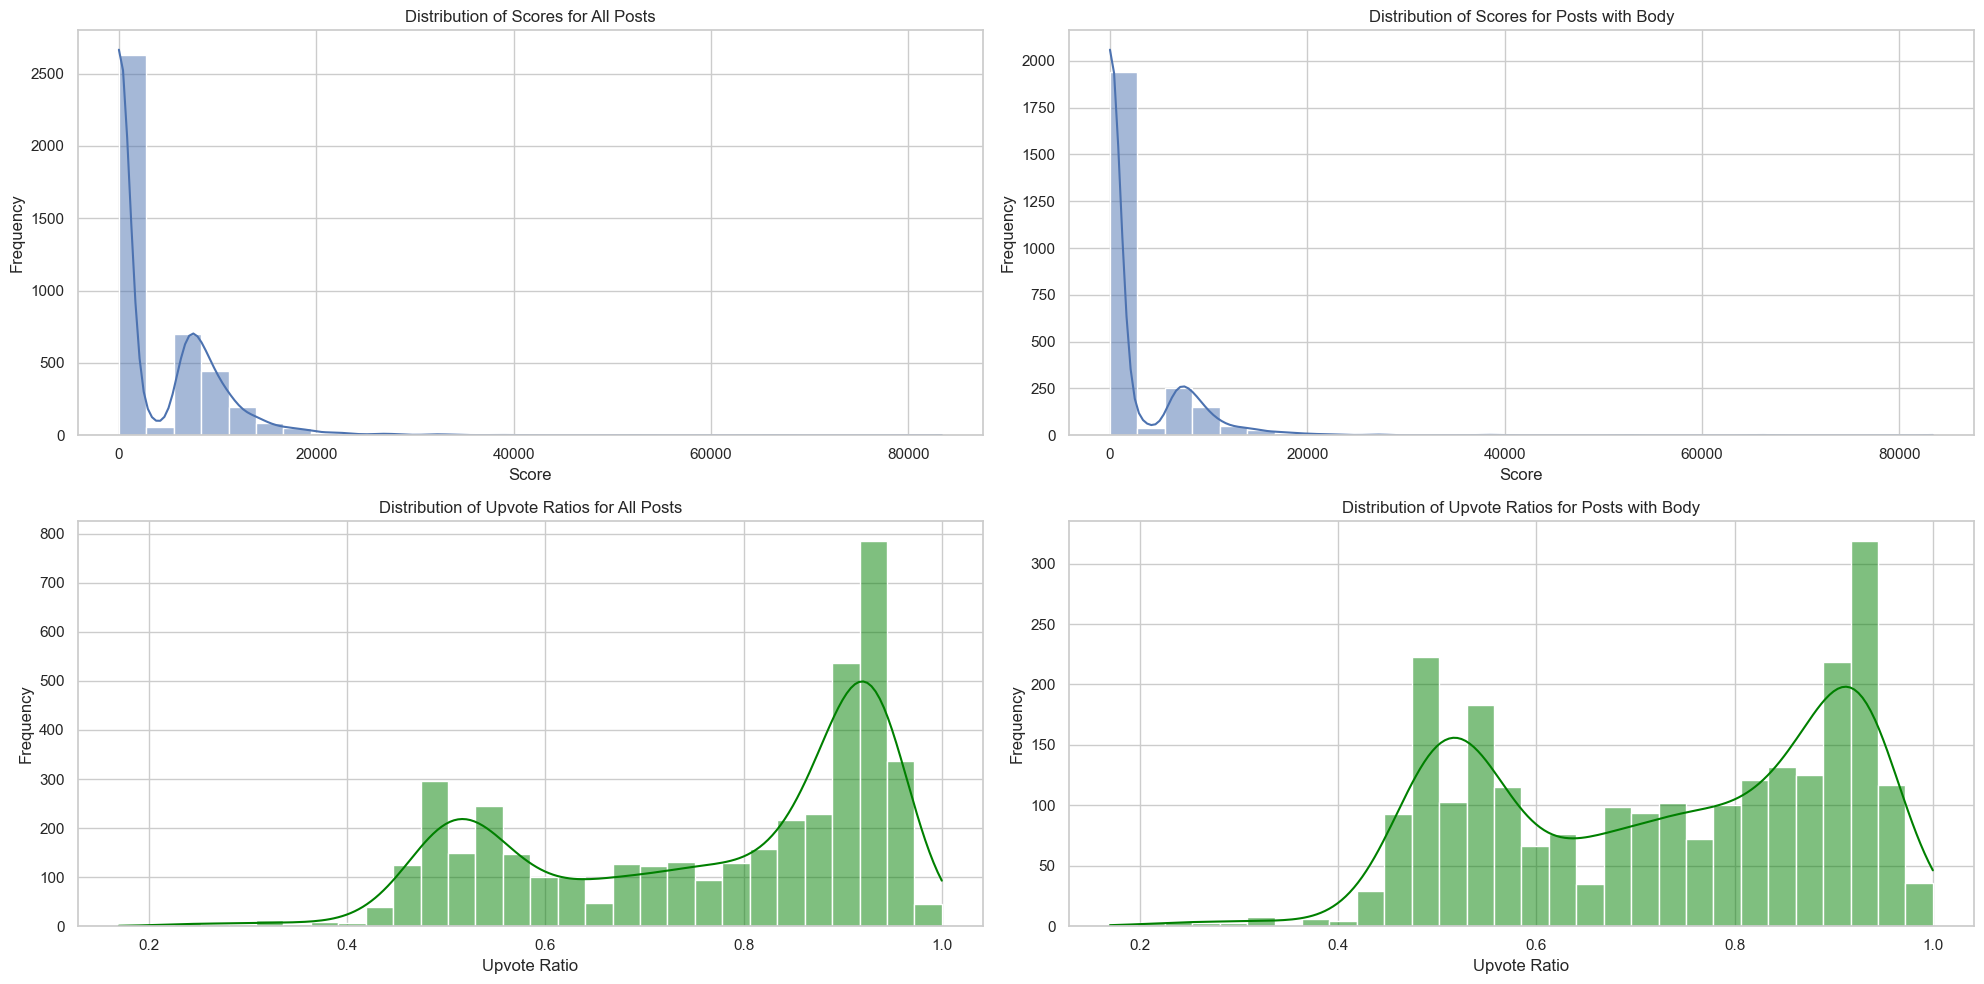

In [8]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 10))  # Overall figure size

# First pair of subplots for the 'score' distributions
plt.subplot(2, 2, 1)  # (rows, columns, panel number)
sns.histplot(reddit_df_retain['score'], bins=30, kde=True)
plt.title('Distribution of Scores for All Posts')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(reddit_df_with_body['score'], bins=30, kde=True)
plt.title('Distribution of Scores for Posts with Body')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Second pair of subplots for the 'upvote_ratio' distributions
plt.subplot(2, 2, 3)
sns.histplot(reddit_df_retain['upvote_ratio'], bins=30, kde=True, color='green')
plt.title('Distribution of Upvote Ratios for All Posts')
plt.xlabel('Upvote Ratio')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(reddit_df_with_body['upvote_ratio'], bins=30, kde=True, color='green')
plt.title('Distribution of Upvote Ratios for Posts with Body')
plt.xlabel('Upvote Ratio')
plt.ylabel('Frequency')

# Improve layout and show plot
plt.tight_layout()
plt.show()


### Observations:

#### Score Distributions:
- **All Posts**: The score distribution for all posts displays a right-skewed pattern with a significant concentration of posts scoring low, but a long tail extends towards extremely high scores. This demonstrates a typical engagement pattern where most posts receive few upvotes, while a minority achieve viral status.
- **Posts with Body**: Similar to the overall trend, posts with body text also exhibit a right-skewed distribution but with a less pronounced tail. This indicates that while these posts tend to receive moderate engagement, they are less likely to reach the extreme scores observed in the broader dataset.

#### Upvote Ratios:
- **All Posts**: The upvote ratio distribution for all posts shows a strong peak around higher values (0.8-1.0), suggesting that the majority of content on the platform is well-received, regardless of the presence of body text.
- **Posts with Body**: Distribution for posts with body text mirrors the general trend but includes slightly more pronounced peaks, particularly in the higher upvote ratio range. This could imply that posts with more detailed content tend to receive a marginally better reception, although the overall pattern of reception remains similar across both groups.

### Need for Focused Comparative Analysis:
To validate these preliminary insights, a focused comparison between 'Posts with Body' and 'Posts with Missing Body' is necessary. This comparison is crucial as the current dataset comparisons between 'All Posts' and 'Posts with Body' have significant overlap, which could lead to misleading conclusions. Further analysis will involve:
- **Isolating Unique Posts**: Separating posts exclusively without body text from those with body text to ensure there's no overlap in the comparison groups.
- **Statistical Testing**: Applying statistical tests to determine if the observed differences in scores and upvote ratios are statistically significant, thereby confirming or refuting the initial observations.
- **Exploring Content Impact**: Examining how the presence of body text influences content engagement and user interactions, potentially informing content strategies and feature engineering for predictive modeling.

These steps will help establish a clearer understanding of the impact of post content depth on user engagement and guide more informed decisions in model development and content strategy optimization.



## Analysis of Posts with Missing Body Text

To gain further insights into the impact of missing body text on post engagement, we isolated posts without body content and conducted a detailed analysis.

We begin by examining the basic statistics and data structure for posts that lack body content. This helps in understanding the scale and characteristics of such posts within our dataset.


In [9]:
# Create a DataFrame of posts where the body is missing
reddit_df_missing_body = reddit_df_retain[reddit_df_retain['body']=='']


# Display basic info about the DataFrame
reddit_df_missing_body.describe()


,datetime,score,upvote_ratio,body_length,body_missing
count,1713,1713.000000,1713.000000,1713.0,1713.0
mean,2019-08-04 10:06:18.821949952,5989.816696,0.823059,0.0,1.0
min,2011-03-18 13:01:15,0.000000,0.250000,0.0,1.0
25%,2018-01-08 04:42:43,14.000000,0.760000,0.0,1.0
50%,2019-09-23 17:22:52,6676.000000,0.900000,0.0,1.0
75%,2022-01-22 20:43:31,9315.000000,0.930000,0.0,1.0
max,2022-12-09 01:11:34,34365.000000,1.000000,0.0,1.0
std,NaN,5866.275377,0.162134,0.0,0.0


### Comparative Analysis of Posts with and Without Body Text

Next, we visualize the distributions of scores and upvote ratios for posts with and without body text. These plots are crucial for understanding the differences in how these posts are received and engaged with by the community.

The distributions will allow us to observe:
- How scores are distributed for posts without body text compared to those with body text.
- The behavior of upvote ratios for these posts, providing insights into how they are received by the community despite the lack of detailed content.

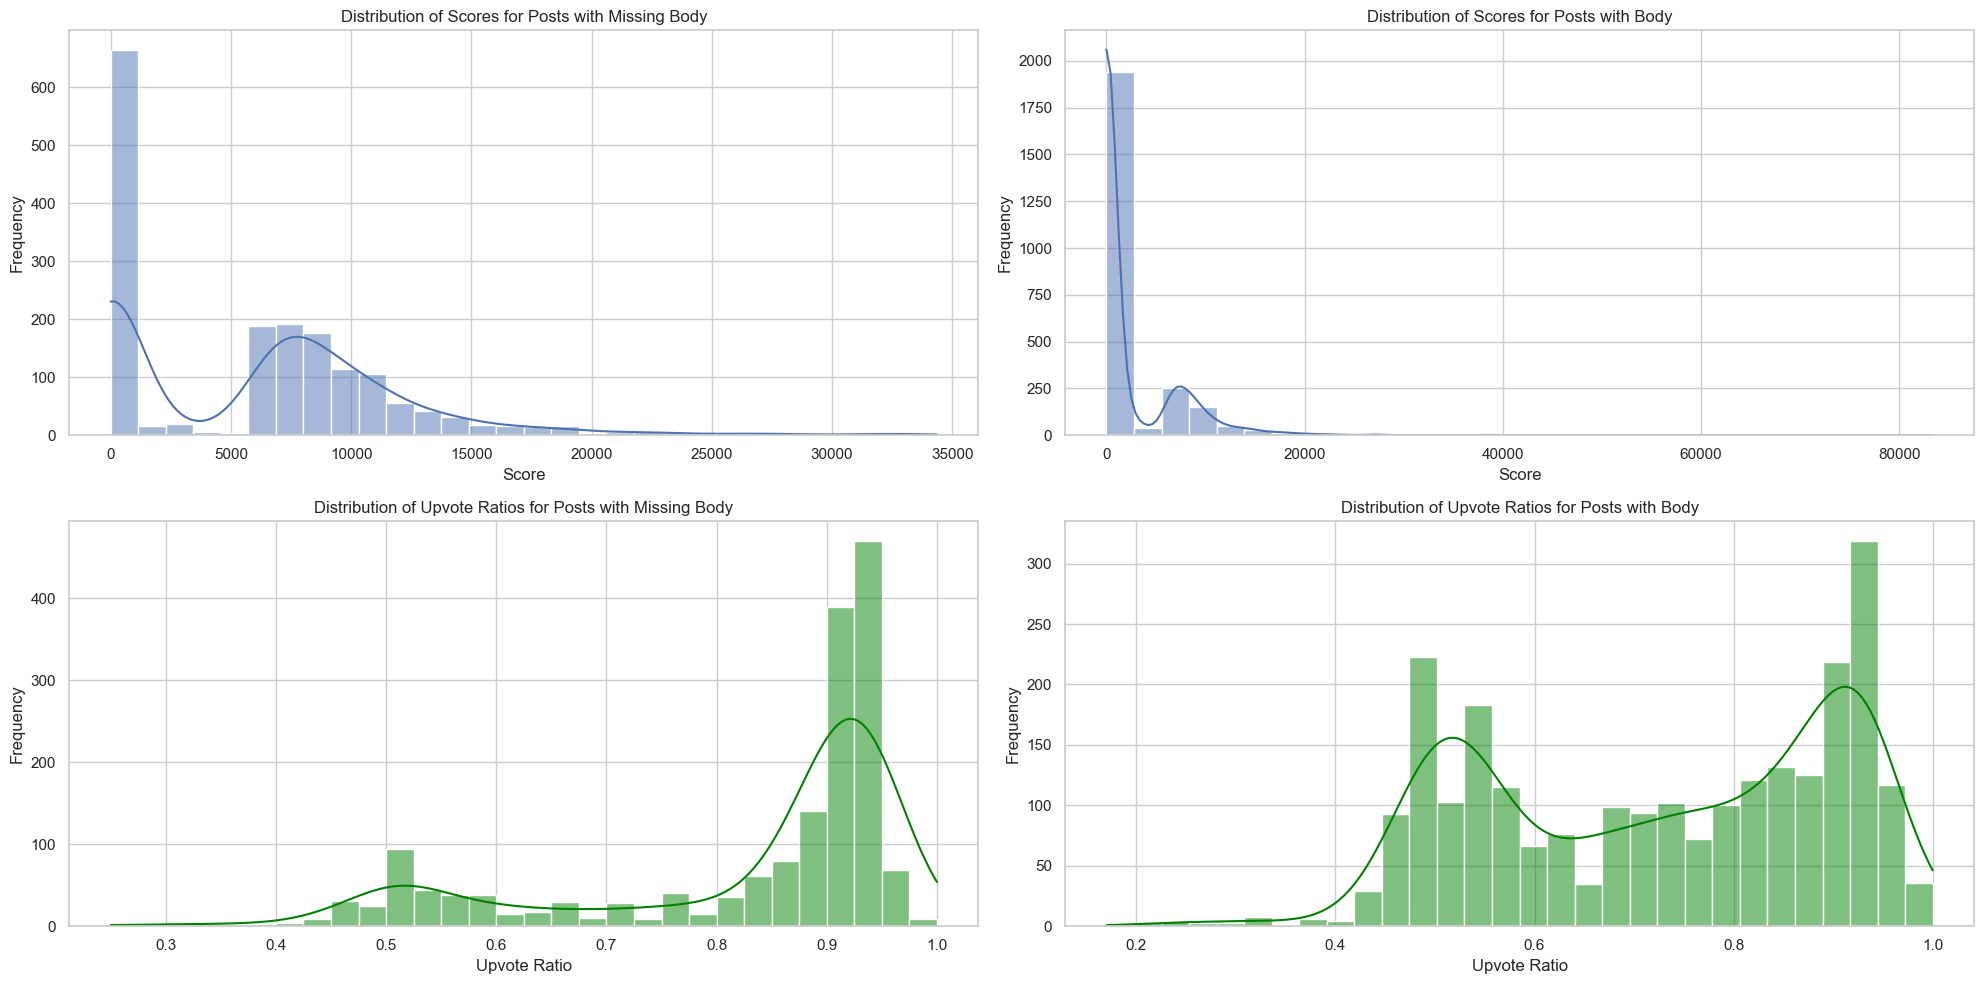

In [10]:
plt.figure(figsize=(20, 10))  # Overall figure size

# First pair of subplots for the 'score' distributions
plt.subplot(2, 2, 1)  # (rows, columns, panel number)
sns.histplot(reddit_df_missing_body['score'], bins=30, kde=True)
plt.title('Distribution of Scores for Posts with Missing Body')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(reddit_df_with_body['score'], bins=30, kde=True)
plt.title('Distribution of Scores for Posts with Body')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Second pair of subplots for the 'upvote_ratio' distributions
plt.subplot(2, 2, 3)
sns.histplot(reddit_df_missing_body['upvote_ratio'], bins=30, kde=True, color='green')
plt.title('Distribution of Upvote Ratios for Posts with Missing Body')
plt.xlabel('Upvote Ratio')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(reddit_df_with_body['upvote_ratio'], bins=30, kde=True, color='green')
plt.title('Distribution of Upvote Ratios for Posts with Body')
plt.xlabel('Upvote Ratio')
plt.ylabel('Frequency')


# Improve layout and show plot
plt.tight_layout()
plt.show()

### Observations:

#### Score Distributions
- **Posts with Missing Body**: The score distribution for posts with missing body text shows a sharp decline and fewer high score occurrences. This suggests that posts without detailed body text generally receive fewer upvotes, indicating potentially lower engagement or value perceived by the readers.
- **Posts with Body**: In contrast, the score distribution for posts with body text is broader and extends into higher score ranges. This reflects that posts with complete content have a higher potential to garner significant engagement and high scores.

#### Upvote Ratio Distributions
- **Posts with Missing Body**: The distribution of upvote ratios for posts without body text shows a significant peak around the 0.9 to 1.0 range, but overall lower frequency across other ratios. This could indicate that while some posts without body text are well-received, the overall engagement is polarized and less consistent.
- **Posts with Body**: The upvote ratio for posts with body text shows a more distributed pattern across the range, with notable peaks in higher ratios. This suggests a generally favorable reception from the community, likely due to the richer content providing more value or generating more discussion.

### Implications:
These findings suggest that the presence of body text in posts significantly impacts both the score and the upvote ratio. Posts with complete body text not only achieve higher scores on average but also exhibit a more favorable reception across a wider range of upvote ratios. This underscores the importance of complete and engaging content for achieving higher engagement and approval on the platform.

The analysis highlights the need to consider post completeness when designing strategies for content creation or when developing algorithms for predicting post popularity. It also provides a data-driven basis for further investigations into how content quality affects user interaction and community engagement.


## Comparative Analysis of Tag Frequencies in Posts With and Without Body Text

Let's explore the frequency of tags in posts that have body text versus those that do not. This analysis is crucial for understanding how the presence or absence of body text affects the discussion of various topics within the subreddit.


In [11]:
# Frequency of tags in posts with missing body
tag_frequency_missing_body = reddit_df_missing_body['tag'].value_counts()

# Frequency of tags in posts with body data
tag_frequency_with_body = reddit_df_with_body['tag'].value_counts()

# Create a DataFrame to display side-by-side
tag_comparison_df = pd.DataFrame({
    'Posts with Body': tag_frequency_with_body,
    'Posts with Missing Body': tag_frequency_missing_body
}).sort_values(by='Posts with Body', ascending=False)

# Fill NaN values with 0 since NaN indicates no occurrences in that dataset
tag_comparison_df.fillna(0, inplace=True)

# Convert NaN to 0 and then to integer
tag_comparison_df = tag_comparison_df.fillna(0).astype(int)

# Print the DataFrame to compare frequencies
print(tag_comparison_df.head(50))


                             Posts with Body  Posts with Missing Body
tag                                                                  
Biology                                  392                      332
Physics                                  390                      238
Human Body                               245                      213
Medicine                                 211                      125
Earth Sciences                           173                      145
Astronomy                                150                      122
Untagged                                 148                       46
Chemistry                                139                       90
COVID-19                                 131                       87
Engineering                              114                       76
Neuroscience                              70                       37
Mathematics                               67                       35
Psychology          

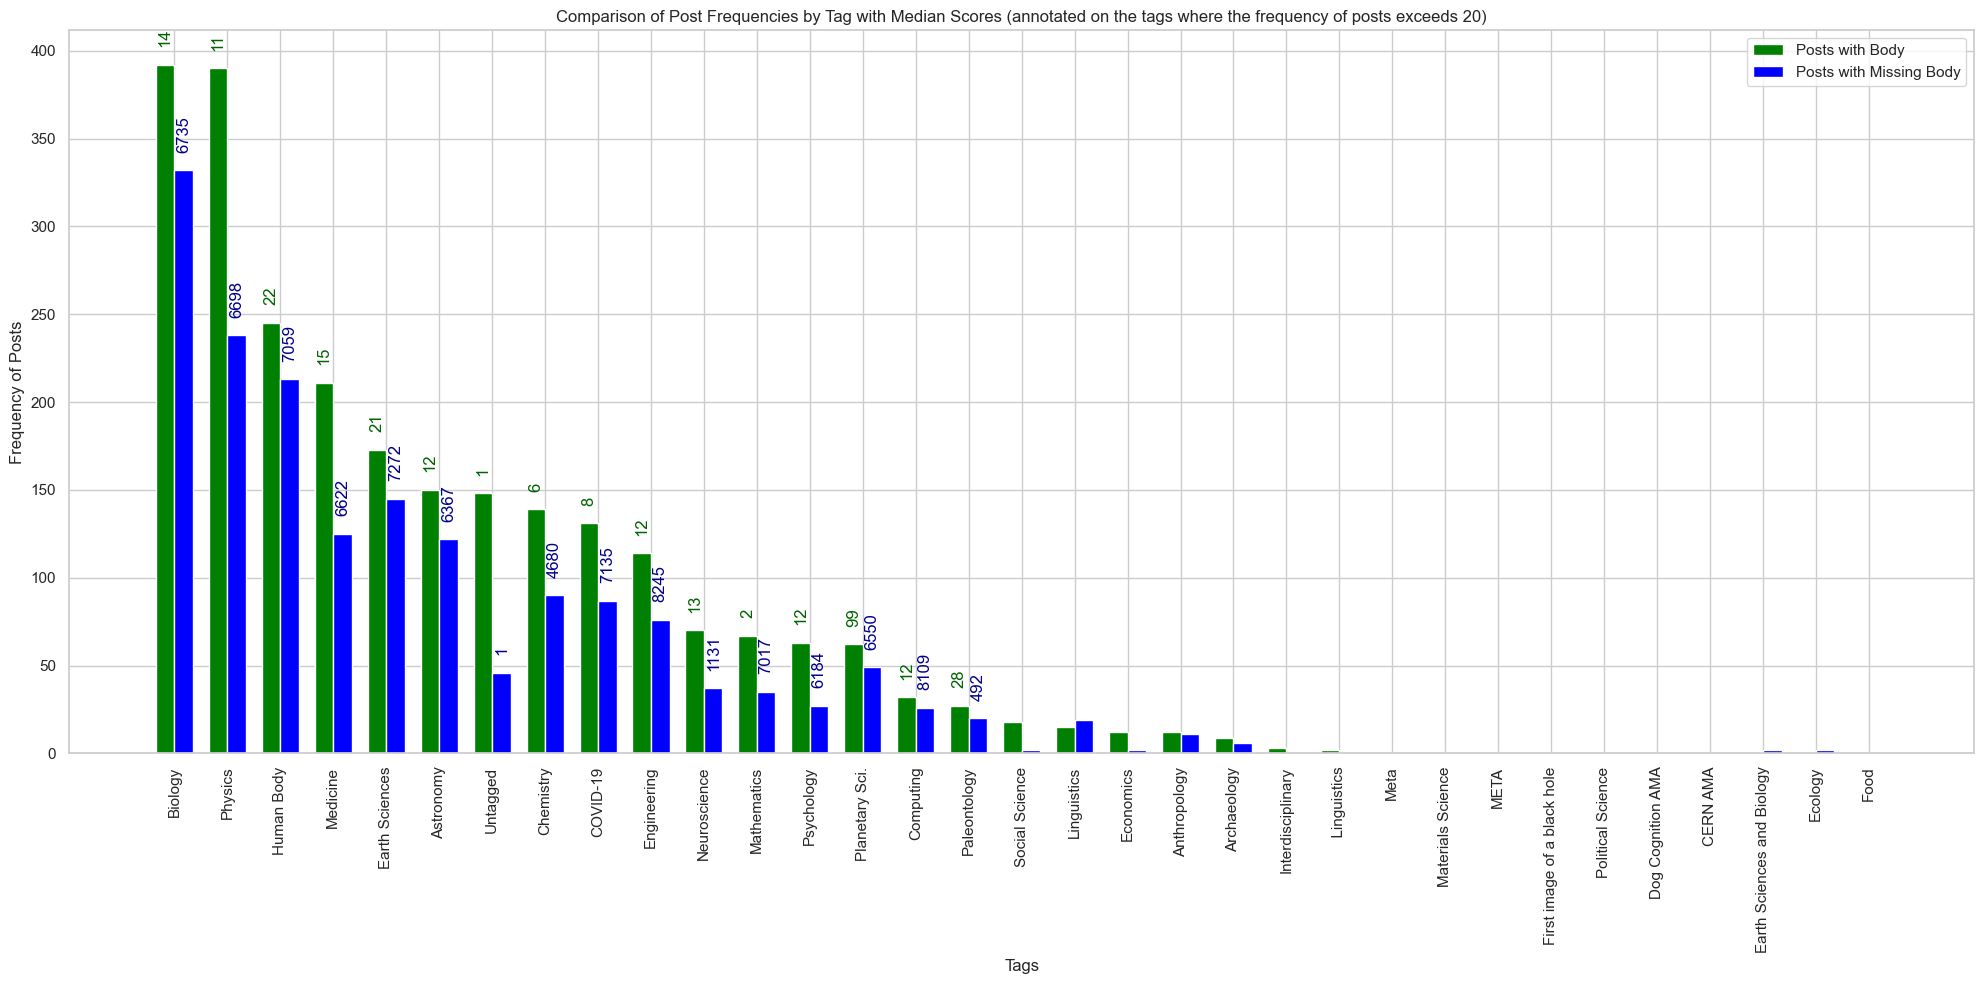

In [12]:
# Calculate median scores by tag for both datasets
median_scores_with_body = reddit_df_with_body.groupby('tag')['score'].median()
median_scores_without_body = reddit_df_missing_body.groupby('tag')['score'].median()

# Create a new DataFrame to store these values
median_scores_df = pd.DataFrame({
    'Median Score with Body': median_scores_with_body,
    'Median Score without Body': median_scores_without_body
})

# Merge this with the existing tag comparison DataFrame
tag_comparison_df = tag_comparison_df.join(median_scores_df)

# Extract tags and corresponding data from the comparison DataFrame
tags = tag_comparison_df.index
y_without_body = tag_comparison_df['Posts with Missing Body']
y_with_body = tag_comparison_df['Posts with Body']
medians_with_body = tag_comparison_df['Median Score with Body']
medians_without_body = tag_comparison_df['Median Score without Body']

# Define the x-axis positions for the groups
x = range(len(tags))

# Create a figure and set its size
plt.figure(figsize=(20, 10))
bar_width = 0.35  # Define the width of each bar for clear separation

# Plot bars for posts with body text
plt.bar(x, y_with_body, width=bar_width, label='Posts with Body', color='green', align='center')

# Plot bars for posts without body text, shifted to the right by bar_width
plt.bar([p + bar_width for p in x], y_without_body, width=bar_width, label='Posts with Missing Body', color='blue', align='center')

# Annotate the bars with median scores if the number of posts is above a threshold of 20
for i in range(len(tags)):
    if y_with_body[i] > 20 or y_without_body[i] > 20:  # Check if post frequency exceeds threshold
        plt.text(x[i], y_with_body[i] + 10, f'{int(medians_with_body[i])}', ha='center', va='bottom', color='darkgreen', rotation=90)
        plt.text(x[i] + bar_width, y_without_body[i] + 10, f'{int(medians_without_body[i])}', ha='center', va='bottom', color='darkblue', rotation=90)

# Set labels and title for the plot
plt.xlabel('Tags')
plt.ylabel('Frequency of Posts')
plt.title('Comparison of Post Frequencies by Tag with Median Scores (annotated on the tags where the frequency of posts exceeds 20)')

# Set x-ticks to be in the middle of the grouped bars and rotate them for better readability
plt.xticks([p + bar_width / 2 for p in x], tags, rotation=90)

# Add a legend to the plot
plt.legend()

# Ensure layout is neat and no overlaps
plt.tight_layout()

# Display the plot
plt.show()


### Observations:
- **Prominent Tags**: Certain tags like 'Biology', 'Physics', and 'Human Body' are frequently represented across both datasets, underscoring the popularity of these topics regardless of the presence or absence of body text in the posts.
- **Differences in Tag Frequency**: Some tags demonstrate noticeable differences in frequency between the datasets with and without body text. For instance, 'Engineering' and 'Medicine' are more prevalent in posts with body text, suggesting that discussions under these tags often require detailed explanations, which are best articulated in a complete post body.
- **Median Scores Annotation**: The median scores, annotated on tags where post frequencies exceed 20, reveal intriguing engagement patterns. Certain tags show higher median scores despite fewer posts, suggesting they may attract intense but concentrated interest, indicating niche areas with potent engagement potential.
- **Posts with Missing Body**: Certain tags, particularly 'Linguistics' and 'Economics', appear more frequently in posts lacking body text. This trend might suggest that discussions under these tags often involve direct questions or succinct topics that can be addressed without extensive background or explanation. Intriguingly, posts without body text often register higher median scores across several tags, potentially indicating that these posts are more likely to be straightforward questions or discussions that elicit quick community response.

### Implications:
Understanding the detailed characteristics of post interactions and tag frequencies provides essential insights for feature engineering and predictive modeling:
- **Tag Influence**: Identifying which tags are associated with detailed discussions versus those often found in concise posts can guide the creation of features that capture the depth of content, potentially influencing the prediction of post engagement and popularity.
- **Post Completeness**: The observation that posts without body text sometimes receive higher median scores suggests incorporating features that account for the presence or absence of body text. This could be crucial for models aimed at predicting user engagement or the popularity of posts.
- **Engagement Indicators**: High median scores in specific tags, regardless of post frequency, indicate strong user interest that could be leveraged to predict hot topics or rising trends within the community.
- **Content Strategy Alignment**: Aligning model outputs with content strategies, such as promoting posts that encourage detailed discussions in scientifically complex tags like 'Engineering' and 'Medicine', can enhance user engagement and content quality on the platform.

By tailoring feature engineering to these observations, the predictive model can be more accurately aligned with actual user interaction patterns, enhancing both the relevance and effectiveness of the model in community management and content strategy applications.

## Author Contribution Analysis

Similarly, we can explore patterns or trends in the activity of certain authors across posts with a body of text and posts without a body of text.

In [13]:
# Frequency of tags in posts with missing body
author_frequency_missing_body = reddit_df_missing_body['author'].value_counts()

# Frequency of tags in posts with body data
author_frequency_with_body = reddit_df_with_body['author'].value_counts()

# Create a DataFrame to display side-by-side
author_comparison_df = pd.DataFrame({
    'Posts with Body': author_frequency_with_body,
    'Posts with Missing Body': author_frequency_missing_body
}).sort_values(by='Posts with Body', ascending=False)

# Fill NaN values with 0 since NaN indicates no occurrences in that dataset
author_comparison_df.fillna(0, inplace=True)

# Convert NaN to 0 and then to integer
author_comparison_df = author_comparison_df.fillna(0).astype(int)

# Print the DataFrame to compare frequencies
print(author_comparison_df.head(20))  

                      Posts with Body  Posts with Missing Body
author                                                        
DELETED                           139                      107
AskScienceModerator                46                        1
inquilinekea                        8                        4
Gargatua13013                       4                        2
AutoModerator                       4                        0
AsAChemicalEngineer                 4                        1
jamx02                              4                        0
ECatPlay                            4                        0
RichardsonM24                       3                        2
Return_of_Hoppetar                  3                        0
VeryLittle                          3                        0
philinho1                           3                        0
tt1702y                             3                        1
Chlorophilia                        3                  

### Key Observation:
Upon examining the posting frequencies by authors in both posts with and without body text, it was observed that most contributions labeled under 'DELETED' indicate removed authors or anonymous posts, which do not provide actionable insights. Furthermore, apart from 'AskScienceModerator', who is likely fulfilling moderation duties, there are no significant or consistent patterns of individual author contributions that would warrant the use of the 'author' feature for predicting post scores.

### Implications:
- **Limited Impactful Contribution**: The data shows that only the 'AskScienceModerator' has a notable number of posts. However, this is likely due to moderation activities rather than content contribution which influences post popularity or engagement inherently linked to scores.

- Given the sporadic and low-frequency contributions from other authors and the predominance of deleted or anonymous posts, this feature does not hold substantial predictive power or relevance for our score prediction model. This decision helps streamline our model by focusing on features that offer more direct insights into content engagement and user interaction.



---
# 5. Feature Engineering
## Overview:
Feature engineering is a critical step in enhancing the predictive power of our models. This process involves creating new features from existing data to provide our models with more informative inputs. Here are the key approaches we are employing for feature engineering in our Reddit post dataset:

- 5.1. **Textual Feature Engineering**
- 5.2. **Time-based Feature Engineering**
- 5.3. **Categorical Encoding**
- 5.4. **Derived Statistical Features (Text Statistics)**

By engineering these features, we aim to build a robust dataset that captures the complexity and nuances of user engagement on Reddit. This will serve as the foundation for our subsequent modeling steps.


### Note:  
> **Focus on `reddit_df_retain` for Feature Engineering**: During our exploratory data analysis (EDA), we observed that posts without body text (available in the `reddit_df_retain` dataset) still manage to attract significant engagement based solely on their titles. This insight leads us to focus on the `reddit_df_retain` dataset for further feature engineering. By doing so, we aim to explore how effectively the title and temporal aspects of posts drive user interaction, regardless of the presence of detailed body text.


## 5.1. Textual Feature Engineering

Textual features are fundamental in capturing the context and sentiment of posts, crucial for predicting user engagement on platforms like Reddit. We will concentrate on extracting meaningful features from post titles, as our exploratory data analysis (EDA) demonstrated that titles alone could significantly attract user attention, even in the absence of body text.

### Features to be Implemented:

1. **SpaCy Embeddings**: We will use SpaCy's pre-trained models to generate embeddings for the titles. These embeddings are advantageous because they provide a rich, contextual representation of the text, capturing deeper semantic meanings that are beneficial for our predictive tasks.

2. **Punctuation Count**: We'll quantify the occurrences of question marks ("?") and exclamation marks ("!") within titles. The frequency of these punctuation marks can be indicative of the nature of the posts, such as inquiries or emphatic expressions, which might influence how users engage with the content.

3. **Sentiment Analysis**: By analyzing the sentiment conveyed in titles, we can gain insights into the emotional tone of the posts, which may correlate with user reactions and engagement levels.

4. **URL Slug Extraction**: We extract and vectorize the last segment of each post’s URL—the slug—as it often contains significant keywords that are reflective of the post’s content. 

5. **Topic Modeling**:To categorize posts into thematic topics, which can be insightful for understanding content trends and user interests.


### Other Considered Options:

While we are primarily using SpaCy embeddings for this project, other vectorization techniques like TF-IDF and Word2Vec were also considered:
- **TF-IDF Vectorization**: This method was not selected because it emphasizes word frequency over context, which might not capture the nuanced semantic relationships necessary for our analysis.
- **Word2Vec Vectorization**: Although Word2Vec provides an understanding of word semantics based on their surrounding words, it lacks the contextual depth that SpaCy's embeddings offer, especially when processing shorter texts like titles where contextual nuance from larger models can be more informative.

### Handling Missing Body Text:
- Given the focus of our analysis on the titles, we are omitting body text. This decision aligns with our findings from the EDA, suggesting that titles alone are capable of capturing significant user interest.

With these textual features, we aim to build a dataset that enriches our models with a comprehensive understanding of the textual data, thus enhancing our ability to predict post engagement effectively. Let's now proceed with the implementation of these textual features.


In [14]:
%%time
# Function to get vector for a document
def get_spacy_vector(text):
    return nlp(text).vector

# Function to get the compound score which represents sentiment
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Function to count specific punctuation marks
def count_punctuation(text, punctuation):
    return text.count(punctuation)

# Adding punctuation count features
reddit_df_retain['question_marks'] = reddit_df_retain['title'].apply(lambda x: count_punctuation(x, '?'))
reddit_df_retain['exclamation_marks'] = reddit_df_retain['title'].apply(lambda x: count_punctuation(x, '!'))


# Applying sentiment analysis to the 'title' column
reddit_df_retain['sentiment'] = reddit_df_retain['title'].apply(get_sentiment)


# Applying the function to each title to get vectors
reddit_df_retain['title_vector'] = reddit_df_retain['title'].apply(get_spacy_vector)

# Print some output to verify
print("Punctuation counts, sentiment analysis and title vectors added to dataframe.")

Punctuation counts, sentiment analysis and title vectors added to dataframe.
CPU times: user 23 s, sys: 99.2 ms, total: 23.1 s
Wall time: 23.2 s


### URL Feature Extraction

The last segment of a post's URL often contains key descriptive elements formatted as a slug—a URL-friendly version of the title. This segment can hold critical insights relevant to the content, making it a valuable asset for predictive modeling. By extracting and vectorizing this URL slug using SpaCy, we capture its semantic essence to enhance the model's understanding of the post's context. This process not only utilizes the natural language components of the URL for feature enrichment but also leverages potential SEO-related benefits that these slugs might embody.

In [15]:
# Function to extract the last part of the URL (the slug)
def extract_url_slug(url):
    return url.split('/')[-2].replace('_', ' ')  # Replace hyphens with spaces to form a proper sentence



# Applying the extraction function
reddit_df_retain['url_slug'] = reddit_df_retain['url'].apply(extract_url_slug)

# Vectorizing the extracted URL slugs
reddit_df_retain['url_vector'] = reddit_df_retain['url_slug'].apply(get_spacy_vector)

# Display a few entries of the new columns to verify
reddit_df_retain[['url', 'url_slug', 'url_vector', 'title']].sample(5)

,url,url_slug,url_vector,title
2702,https://www.reddit.com/r/askscience/comments/1...,does a lightning bolt have a shadow,"[-1.8104199, 5.811342, -4.449543, 1.8987571, 2...",Does a lightning bolt have a shadow?
711,https://www.reddit.com/r/askscience/comments/u...,is there any truth to the idea that were now too,"[-1.5185406, 4.232964, -2.3833535, -1.09262, 1...",Is there any truth to the idea that we're now ...
2652,https://www.reddit.com/r/askscience/comments/a...,how come some people can see 3d and some cant,"[1.817971, 3.3336637, -5.6710453, -2.2193277, ...",How come some people can see 3D and some can't?
3760,https://www.reddit.com/r/askscience/comments/s...,how are rabies vaccines made,"[-2.489824, 0.6235999, -1.846986, -2.48076, 2....",How are rabies vaccines made?
1911,https://www.reddit.com/r/askscience/comments/7...,why does a passing car horn reduce in pitch,"[-1.2001456, 3.8207636, -3.414199, -0.47819674...",Why does a passing car horn reduce in pitch?


### Topic Modeling

Topic modeling, specifically through Latent Dirichlet Allocation (LDA), helps uncover hidden thematic structures in the Reddit post titles. The key challenge is selecting the optimal number of topics.

#### Optimal Number of Topics

The optimal number of topics is determined based on coherence scores, which measure the semantic similarity between high scoring words within a topic. Here's how we determine the best number:

1. **Coherence Score Evaluation**: Calculate coherence scores across various numbers of topics to assess how meaningful the discovered topics are.
2. **Selecting the Number**: Choose the number of topics where the coherence score peaks, indicating a balance between too many and too few topics.
3. **Validation**: Examine the top terms of the topics to ensure they are distinct and interpretable.

This streamlined process ensures that the topics are both statistically significant and relevant for further analysis and predictive modeling.

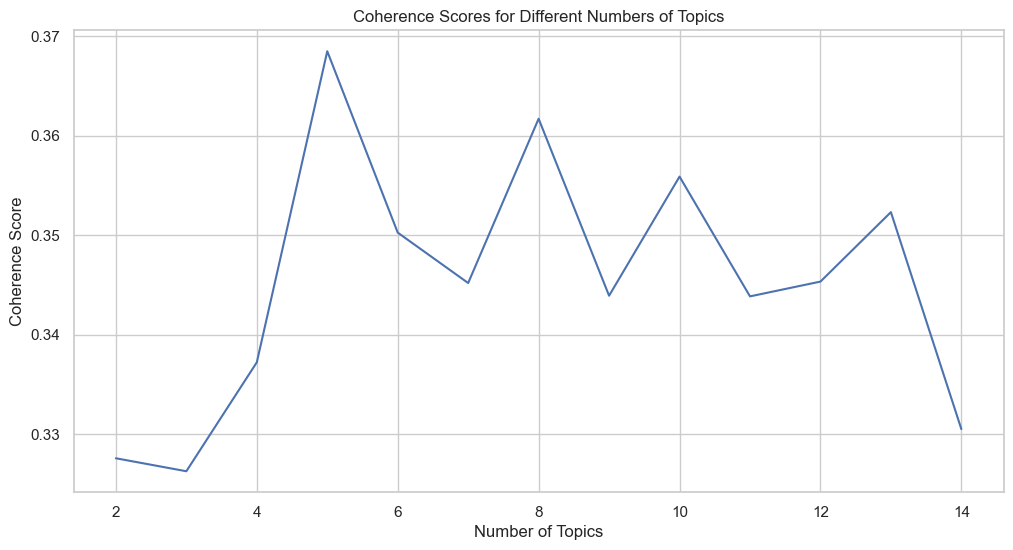

CPU times: user 14.5 s, sys: 1.87 s, total: 16.3 s
Wall time: 1min 35s


In [16]:
%%time
# Tokenize documents
tokenized_docs = [doc.split() for doc in reddit_df_retain['title']]

# Create a dictionary representation of the documents
dictionary = Dictionary(tokenized_docs)

# Convert dictionary to a bag of words corpus
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

coherence_scores = []
n_topics_list = range(2, 15)  # Testing from 2 to 14 topics

for n_topics in n_topics_list:
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, random_state=42, iterations=400)
    coherence_model = CoherenceModel(model=lda, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())


plt.figure(figsize=(12, 6))
plt.plot(n_topics_list, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for Different Numbers of Topics")
plt.show()


In [17]:
# Topic Modeling
count_vectorizer = CountVectorizer(max_features=100)
dtm = count_vectorizer.fit_transform(reddit_df_retain['title'])

# Initialize LDA with 5 topics, chosen based on analysis of coherence scores indicating optimal topic separation
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(dtm)

# Transform the document-term matrix with LDA and convert the result into a DataFrame
lda_transformed = lda.transform(dtm)
df_lda = pd.DataFrame(lda_transformed, columns=[f"lda_{i}" for i in range(lda_transformed.shape[1])])

# Reset index on the main DataFrame to ensure alignment when concatenating
reddit_df_retain.reset_index(drop=True, inplace=True)

# Concatenate the LDA topic distribution DataFrame to the main DataFrame
reddit_df_retain = pd.concat([reddit_df_retain, df_lda], axis=1)

# Output to check if the features are added correctly
print("LDA topic features added to DataFrame.")

LDA topic features added to DataFrame.


## 5.2. Time-based Feature Engineering

To capture the influence of posting times on user engagement, we will engineer several time-based features from the `datetime` column. These features will facilitate a deeper analysis of patterns across different timescales, which may impact post popularity.

### Features to be Created:

1. **Year, Month, and Day of the Week**: These features will help in analyzing seasonal and weekly patterns in post interactions.
2. **Time of the Day**: Extracting the hour from the timestamp will allow us to see if posts perform better during specific times of the day (e.g., morning, afternoon, evening). Additionally, we will categorize the time into AM/PM to simplify the model's understanding of day parts.
3. **Elapsed Time**: By calculating the time elapsed from the most recent post in the dataset, we can incorporate a sense of recency into our model. This feature assumes that the latest timestamp in our data is the time of data collection.

These engineered features aim to provide our predictive model with nuanced insights into how timing impacts post engagement, which is crucial for effectively predicting the popularity of posts on Reddit.


In [18]:
# Extract year, month, day of the week, and hour
reddit_df_retain['year'] = reddit_df_retain['datetime'].dt.year
reddit_df_retain['month'] = reddit_df_retain['datetime'].dt.month
reddit_df_retain['day_of_week'] = reddit_df_retain['datetime'].dt.dayofweek
reddit_df_retain['hour'] = reddit_df_retain['datetime'].dt.hour
reddit_df_retain['period'] = reddit_df_retain['datetime'].dt.strftime('%p')  # AM or PM

# Calculate elapsed time from the latest post
latest_time = reddit_df_retain['datetime'].max()
reddit_df_retain['elapsed_time'] = (latest_time - reddit_df_retain['datetime']).dt.total_seconds() / 3600  # in hours

# Display the dataframe to check new features
reddit_df_retain[['datetime', 'year', 'month', 'day_of_week', 'hour', 'period', 'elapsed_time', 'score']].sample(5)


,datetime,year,month,day_of_week,hour,period,elapsed_time,score
47,2017-06-23 05:16:12,2017,6,4,5,AM,47887.830278,22404.0
3134,2019-12-21 05:38:55,2019,12,5,5,AM,26023.451667,6893.0
1758,2015-02-11 00:15:42,2015,2,2,0,AM,68604.838611,0.0
355,2020-03-03 04:59:11,2020,3,1,4,AM,24272.113889,9903.0
55,2020-10-01 22:47:27,2020,10,3,22,PM,19166.309444,20387.0


## 5.3. Categorical Encoding

Transforming categorical variables into a numerical format is essential, as most predictive models cannot directly handle categorical strings. In our analysis of Reddit post data, we focus on encoding:

- **Tag Feature**: Utilizing OneHotEncoder to transform the `tag` feature, which represents different post categories. This encoding helps the model capture patterns associated with different topics, potentially impacting post popularity and engagement.

- **Time-Based Features**: Converting time-related features like `year`, `month`, `day_of_week`, and `hour` into integers to maintain their ordinal nature and improve model interpretability.

Since most models can't directly handle categorical strings, we need to transform these variables into a numerical format. For our Reddit post data, we will focus on encoding the tag feature and the time-based features we extracted earlier. Encoding these features helps the model to understand the patterns associated with different categories and times, which can significantly influence post popularity and engagement.

**Note on Exclusion**: We exclude the 'author' feature from our modeling due to its high cardinality and low predictive value, with many entries labeled as 'DELETED' or representing infrequent or anonymous authors, providing limited information for prediction.

In [19]:
# List of categorical features to encode
categorical_features = ['tag', 'year', 'month', 'day_of_week', 'hour', 'period']


# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the categorical feature 'tag'
encoded_features = encoder.fit_transform(reddit_df_retain[categorical_features])

# Create a DataFrame from the encoded features
# Use the original category names from 'tag' and prefix them
feature_names = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)

# Ensure DataFrame indices are aligned before concatenating
reddit_df_retain.reset_index(drop=True, inplace=True)

# Concatenate the encoded features back to the main DataFrame
reddit_df_retain = pd.concat([reddit_df_retain, encoded_df], axis=1)

# Output to verify that the features have been encoded and added
print("Categorical features encoded and added to DataFrame.")

Categorical features encoded and added to DataFrame.


## 5.4. Derived Statistical Features (Text Statistics)

In addition to other textual features, we'll calculate and incorporate various text statistics such as word, sentence, and character counts from the post titles to explore potential correlations with user engagement. These metrics provide insights into the content's complexity and richness, which could influence how users interact with the posts.

Additionally, we are utilizing the `body_length` feature, which measures the length of the post content where available and assigns a zero for posts with missing bodies. This feature helps capture the extent of information presented in the posts and will be considered in our predictive modeling to assess its impact on user engagement.

In [20]:
# Calculate word count
reddit_df_retain['word_count'] = reddit_df_retain['title'].apply(lambda x: len(x.split()))

# Calculate sentence count
reddit_df_retain['sentence_count'] = reddit_df_retain['title'].apply(lambda x: x.count('.') + x.count('!') + x.count('?') + 1)  # Simple heuristic

# Calculate character count
reddit_df_retain['character_count'] = reddit_df_retain['title'].apply(len)

# Display the first few entries to verify the newly added features
reddit_df_retain[['title', 'word_count', 'sentence_count', 'character_count', 'body_length']].head()


,title,word_count,sentence_count,character_count,body_length
0,Post viral cough: why does it get worse after ...,12,2,61,1544
1,Can an x-ray of an adult show chronic malnouri...,11,2,66,241
2,[META] Bots and AI tools on r/askscience,7,1,40,522
3,Can you predictably manipulate a magnetic gas?,7,2,46,547
4,Are there cells in humans (or other mammals) t...,13,2,73,0


---
# 6. Model Preparation

Proper model preparation is critical for developing an effective predictive model. This phase ensures that our dataset is optimized for training and evaluation, focusing on feature selection, data splitting, and any necessary data transformations.

## Steps in Model Preparation:

1. **Feature Selection**:
   - We carefully select features that are most likely to influence the target variable, eliminating redundant or irrelevant features to streamline the model and enhance performance.

2. **Data Splitting**:
   - The dataset is divided into training and testing sets to ensure the model is trained on a comprehensive sample and validated on unseen data, typically using a 80-20 split for training and testing, respectively.

3. **Scaling and Normalization** (if required):
   - Some models require feature scaling to prevent attributes with larger scales from dominating those in smaller scales, improving model fairness and efficiency.

4. **Handling Imbalanced Data** (if necessary):
   - If the target variable classes are imbalanced, we may apply techniques like oversampling or undersampling to balance class distribution, ensuring the model doesn't bias toward the majority class.

This structured approach to model preparation sets the foundation for building a robust model that is both accurate and reliable.

In [21]:
print(reddit_df_retain.columns.tolist())

['title', 'body', 'tag', 'datetime', 'author', 'score', 'upvote_ratio', 'url', 'body_length', 'body_missing', 'question_marks', 'exclamation_marks', 'sentiment', 'title_vector', 'url_slug', 'url_vector', 'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4', 'year', 'month', 'day_of_week', 'hour', 'period', 'elapsed_time', 'tag_  Linguistics', 'tag_Anthropology', 'tag_Archaeology', 'tag_Astronomy', 'tag_Biology', 'tag_CERN AMA', 'tag_COVID-19', 'tag_Chemistry', 'tag_Computing', 'tag_Dog Cognition AMA', 'tag_Earth Sciences', 'tag_Earth Sciences and Biology', 'tag_Ecology', 'tag_Economics', 'tag_Engineering', 'tag_First image of a black hole', 'tag_Food', 'tag_Human Body', 'tag_Interdisciplinary', 'tag_Linguistics', 'tag_META', 'tag_Materials Science', 'tag_Mathematics', 'tag_Medicine', 'tag_Meta', 'tag_Neuroscience', 'tag_Paleontology', 'tag_Physics', 'tag_Planetary Sci.', 'tag_Political Science', 'tag_Psychology', 'tag_Social Science', 'tag_Untagged', 'year_2010', 'year_2011', 'year_2012', 'year

### Outlier Analysis in Post Scores

The distribution of Reddit post scores shows a significant range, with outliers potentially influencing the mean (red dashed line). The 25th and 75th percentiles (green dashed lines) represent the interquartile range, indicating where the bulk of scores reside. This analysis is crucial for deciding whether to adjust or remove outliers to improve the predictive model's accuracy and robustness.

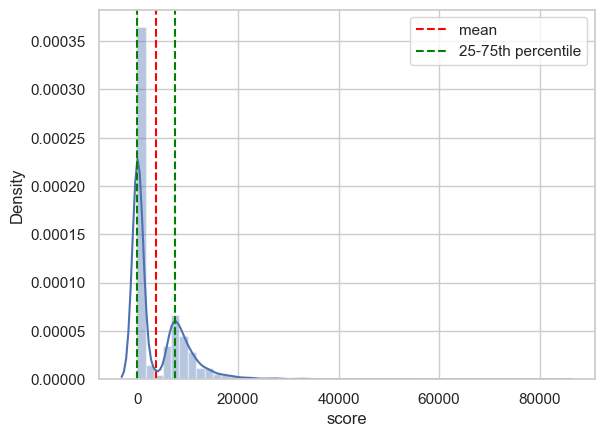

In [ ]:
sns.distplot(reddit_df_retain['score'])
plt.axvline(x=np.mean(reddit_df_retain['score']), c='red', ls='--', label='mean')
plt.axvline(x=np.percentile(reddit_df_retain['score'],25), c='green', ls='--', label='25-75th percentile')
plt.axvline(x=np.percentile(reddit_df_retain['score'],75), c='green', ls='--')
plt.legend()

In [22]:
# To remove outliers
def remove_outliers(df, column_list):
    for column in column_list:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Columns to check for outliers
columns_to_check = ['score', 'body_length']

# Removing outliers
reddit_df_retain_clean = remove_outliers(reddit_df_retain, columns_to_check)
print(f"Data before outlier removal: {reddit_df_retain.shape}")
print(f"Data after outlier removal: {reddit_df_retain_clean.shape}")


Data before outlier removal: (4205, 121)
Data after outlier removal: (3919, 121)


### Feature Selection & Data Splitting

In [26]:
# Initialize the MinMaxScaler
minmax_scaler = MinMaxScaler()

# Assuming 'title_vector' is a list of lists (300-dimensional vectors)
# Convert to a NumPy array
vectors = np.array(reddit_df_retain['title_vector'].tolist())

# Standardize features
# scaler = StandardScaler()
vectors_scaled = minmax_scaler.fit_transform(vectors)

features = ['body_length', 'body_missing', 'question_marks', 'exclamation_marks', 'sentiment', 
            'upvote_ratio',
            'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4', 
            'elapsed_time', 
            'tag_  Linguistics', 'tag_Anthropology', 'tag_Archaeology', 'tag_Astronomy', 'tag_Biology', 
            'tag_CERN AMA', 'tag_COVID-19', 'tag_Chemistry', 'tag_Computing', 'tag_Dog Cognition AMA', 
            'tag_Earth Sciences', 'tag_Earth Sciences and Biology', 'tag_Ecology', 'tag_Economics', 
            'tag_Engineering', 'tag_First image of a black hole', 'tag_Food', 'tag_Human Body', 
            'tag_Interdisciplinary', 'tag_Linguistics', 'tag_META', 'tag_Materials Science', 
            'tag_Mathematics', 'tag_Medicine', 'tag_Meta', 'tag_Neuroscience', 'tag_Paleontology', 
            'tag_Physics', 'tag_Planetary Sci.', 'tag_Political Science', 'tag_Psychology', 
            'tag_Social Science', 'tag_Untagged', 
            'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015', 
            'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 
            'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
            'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 
            'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 
            'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
            'period_AM', 'period_PM', 
            'word_count', 'sentence_count', 'character_count']


# Concatenate with other features
other_features = reddit_df_retain[features].values  # Include other relevant features
other_features_scaled = minmax_scaler.fit_transform(other_features)  # Scale these features

X = np.hstack([vectors_scaled, other_features_scaled])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, reddit_df_retain['score'], test_size=0.2, random_state=42)


# Fit the scaler to the training target and transform it
y_train_scaled = minmax_scaler.fit_transform(y_train.values.reshape(-1, 1))

# Apply the same transformation to the test target
y_test_scaled = minmax_scaler.transform(y_test.values.reshape(-1, 1))

---
<a id="Predictive Modeling"></a>
# 7. Predictive Modeling

Predictive modeling is a critical phase in our data science workflow, where we apply various machine learning techniques to the prepared dataset to predict outcomes effectively. This phase is designed to iteratively refine models through experimentation, evaluation, and optimization.

## Key Steps in Predictive Modeling:

1. **Baseline Model Establishment**:
   - Begin with a simple baseline model to set a benchmark for performance. This model serves as a reference point for all subsequent, more complex models.

2. **Advanced Model Development**:
   - Explore a variety of machine learning algorithms to identify the most effective approach for our specific dataset. Potential models include decision trees, ensemble methods like Random Forest and Gradient Boosting Machines, as well as deep learning architectures, depending on the complexity and nature of the data.

3. **Hyperparameter Optimization**:
   - Utilize methods such as grid search or random search to optimize model parameters. This step is crucial for enhancing model performance and ensuring efficiency.

4. **Robust Validation Techniques**:
   - Implement cross-validation techniques to gauge the model’s performance stability and its ability to generalize to new data. This helps in mitigating overfitting and underfitting scenarios.

5. **Comprehensive Model Evaluation**:
   - Evaluate models using metrics tailored to the specific goals of the project, such as precision, recall, F1 score for classification tasks, and RMSE or MAE for regression tasks. This evaluation guides the selection of the final model.

6. **Final Model Selection**:
   - Choose the best-performing model based on evaluation metrics and business objectives. This model will then be fine-tuned and potentially deployed.

7. **Deployment Preparation** (if applicable):
   - Ready the selected model for deployment by ensuring it can handle real-time data and integrate seamlessly into existing production environments.

This section of the project is vital as it directly influences the accuracy and applicability of the predictive insights derived from the model. Careful attention to detail and rigorous testing are essential to ensure that the final model is both accurate and practical for decision-making processes.

## RandomForestRegressor as Baseline Model

In [27]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the RandomForestRegressor as Baseline Model 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_scaled)

# Predictions and evaluation
y_pred_scaled = rf_model.predict(X_test)

In [30]:
from sklearn.metrics import mean_squared_error, r2_score

mse_rf = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"Mean Squared Error for RandomForestRegressor (scaled): {mse_rf}")

r_squared = r2_score(y_test_scaled, y_pred_scaled)
print(f"R-squared: {r_squared}")

Mean Squared Error for RandomForestRegressor (scaled): 0.0012408515501361633
R-squared: 0.7540476685226543


In [31]:
# Inverse the scaling if y was scaled, necessary to interpret the RMSE in the original units of y
y_pred_rescaled = minmax_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_rescaled = minmax_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))


mse_rf = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Squared Error for RandomForestRegressor (rescaled): {mse_rf}")

r_squared = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"R-squared: {r_squared}")

Mean Squared Error for RandomForestRegressor (rescaled): 8627092.277406868
R-squared: 0.7540476685226543


### Note: Exploring Relative Errors in Predictions

Understanding the relative difference between the predicted and actual scores is crucial, especially in datasets where the target variable can vary widely. Absolute error metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) can be misleading in contexts where the values being predicted have a large range. For example, an absolute error of 100 might be insignificant when predicting values around 2500 but critical when the actual values are near 10.

Relative error considers the size of the actual values when assessing the accuracy of predictions. It provides a percentage that represents the size of the error relative to the actual values, offering a clearer understanding of how significant the errors are across different scales of data.

### Consideration of Feature Selection: Upvote Ratio

Including the `upvote_ratio` as a feature in the predictive model training may introduce biases, as it is likely correlated with the `score` of a post. The upvote ratio essentially represents a direct metric of user engagement, similar to score but normalized against downvotes. Using `upvote_ratio` alongside `score` could lead to data leakage, where the model inadvertently learns from data that implies the target outcome. It's advisable to exclude `upvote_ratio` from the feature set to ensure that the model learns to predict scores based solely on independent variables, thus enhancing its ability to generalize to new, unseen data effectively.

### Re-training the Baseline Model Excluding `upvote_ratio` Data

In [42]:
# Initialize the MinMaxScaler
minmax_scaler = MinMaxScaler()

# Assuming 'title_vector' is a list of lists (300-dimensional vectors)
# Convert to a NumPy array
vectors = np.array(reddit_df_retain['title_vector'].tolist())

# Standardize features
# scaler = StandardScaler()
vectors_scaled = minmax_scaler.fit_transform(vectors)

features = ['body_length', 'body_missing', 'question_marks', 'exclamation_marks', 'sentiment', 
            # 'upvote_ratio',
            'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4', 
            'elapsed_time', 
            'tag_  Linguistics', 'tag_Anthropology', 'tag_Archaeology', 'tag_Astronomy', 'tag_Biology', 
            'tag_CERN AMA', 'tag_COVID-19', 'tag_Chemistry', 'tag_Computing', 'tag_Dog Cognition AMA', 
            'tag_Earth Sciences', 'tag_Earth Sciences and Biology', 'tag_Ecology', 'tag_Economics', 
            'tag_Engineering', 'tag_First image of a black hole', 'tag_Food', 'tag_Human Body', 
            'tag_Interdisciplinary', 'tag_Linguistics', 'tag_META', 'tag_Materials Science', 
            'tag_Mathematics', 'tag_Medicine', 'tag_Meta', 'tag_Neuroscience', 'tag_Paleontology', 
            'tag_Physics', 'tag_Planetary Sci.', 'tag_Political Science', 'tag_Psychology', 
            'tag_Social Science', 'tag_Untagged', 
            'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015', 
            'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 
            'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
            'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 
            'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 
            'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
            'period_AM', 'period_PM', 
            'word_count', 'sentence_count', 'character_count']


# Concatenate with other features
other_features = reddit_df_retain[features].values  # Include other relevant features
other_features_scaled = minmax_scaler.fit_transform(other_features)  # Scale these features

X = np.hstack([vectors_scaled, other_features_scaled])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, reddit_df_retain['score'], test_size=0.2, random_state=42)


# Fit the scaler to the training target and transform it
y_train_scaled = minmax_scaler.fit_transform(y_train.values.reshape(-1, 1))

# Apply the same transformation to the test target
y_test_scaled = minmax_scaler.transform(y_test.values.reshape(-1, 1))


In [43]:
# Initialize and train the RandomForestRegressor as Baseline Model 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_scaled)

# Predictions and evaluation
y_pred_scaled = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"Mean Squared Error for RandomForestRegressor (scaled): {mse_rf}")

r_squared = r2_score(y_test_scaled, y_pred_scaled)
print(f"R-squared: {r_squared}")

Mean Squared Error for RandomForestRegressor (scaled): 0.0019955448884437575
R-squared: 0.6044579886880235


### Impact of Excluding `upvote_ratio` from Model Training

The observed decrease in R-squared upon removing `upvote_ratio` from the model's features underscores the significant influence this variable had on predicting the post score. Initially, the higher R-squared value suggested that the model was able to explain a large variance in the scores using `upvote_ratio` alongside other features. However, this could be attributed to data leakage, as `upvote_ratio` is directly related to user engagement, similar to the target variable `score`.

The drop in R-squared upon excluding `upvote_ratio` might indicate a more realistic predictive performance of the model when relying on truly independent variables. While this reduction in model accuracy might seem unfavorable, it likely represents a more accurate reflection of the model's capability to generalize to new data without relying on potentially biased or correlated features. This is crucial for building a robust model that genuinely understands underlying patterns rather than leveraging direct or indirect information about the outcome variable.

## **Model Building and Tuning**

## XGBoost Model

In [46]:
import xgboost as xgb

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1,
                             max_depth=3, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train_scaled)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate and print the mean squared error
mse_xgb = mean_squared_error(y_test_scaled, y_pred_xgb)
print(f"Mean Squared Error for XGBoost: {mse_xgb}")

r_squared = r2_score(y_test_scaled, y_pred_xgb)
print(f"R-squared for XGBoost: {r_squared}")

Mean Squared Error for XGBoost: 0.0022248095548784157
R-squared for XGBoost: 0.5590148579373768


##  XGBoost Model after Feature Preprocessing and PCA

In [47]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


# Define a pipeline with PCA and XGBoost Regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),  # Adjust based on PCA analysis
    ('regressor', XGBRegressor())
])

# Grid search for hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train_scaled)

# Evaluate the model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(-grid_search.best_score_))

# Predict and evaluate on the test set
y_pred_grid = grid_search.predict(X_test)
mse_grid = mean_squared_error(y_test_scaled, y_pred_grid)
print("Test set MSE: {:.2f}".format(mse_grid))

r_squared_grid = r2_score(y_test_scaled, y_pred_grid)
print(f"R-squared for XGBoost: {r_squared_grid}")

Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 7, 'regressor__n_estimators': 100}
Best cross-validation score: 0.00
Test set MSE: 0.00
R-squared for XGBoost: 0.48277998251477605


## Simplified Neural Network Model

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1048 - mae: 0.2429 - val_loss: 0.0110 - val_mae: 0.0838
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.0106 - mae: 0.0807 - val_loss: 0.0075 - val_mae: 0.0675
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 0.0075 - mae: 0.0651 - val_loss: 0.0060 - val_mae: 0.0596
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 0.0061 - mae: 0.0588 - val_loss: 0.0051 - val_mae: 0.0551
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - loss: 0.0054 - mae: 0.0547 - val_loss: 0.0046 - val_mae: 0.0519
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.0044 - mae: 0.0506 - val_loss: 0.0042 - val_mae: 0.0498
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.0059 - mae: 0.0508 - val_loss: 0.0041 - val_mae: 0.0482
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.0048 - mae: 0.0476 - val_loss: 0.0038 - val_mae: 0.0459
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/st

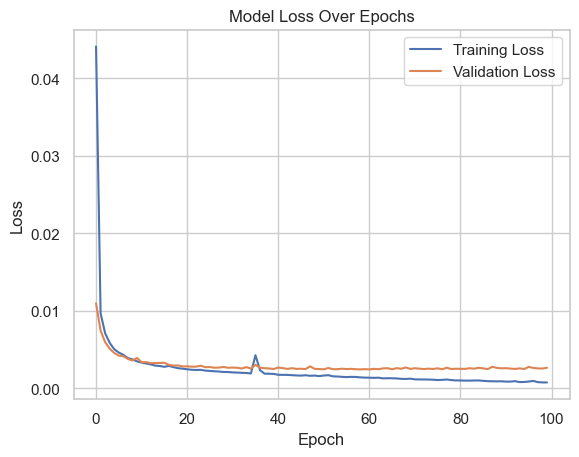

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


# Model Definition
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Model Compilation
nn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Model Training
history = nn_model.fit(X_train, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Prediction and Evaluation
y_pred_scaled = model.predict(X_test)
y_pred = minmax_scaler.inverse_transform(y_pred_scaled)
y_test_rescaled = minmax_scaler.inverse_transform(y_test_scaled)

# Calculate MSE and other metrics
mse = mean_squared_error(y_test_rescaled, y_pred)
print(f"Test MSE: {mse}")

# Optionally, visualize the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [65]:
# Calculate MSE and other metrics
mse_nn = mean_squared_error(y_test_rescaled, y_pred)
print(f"Test MSE for Neural Network Model: {mse_nn}")

# Calculate the R-squared score
r_squared_nn = r2_score(y_test_rescaled, y_pred)
print(f"R-squared for Neural Network Model: {r_squared_nn}")

Test MSE for Neural Network Model: 17247524.663809523
R-squared for Neural Network Model: 0.508285205852457


## 8. Insights and Conclusion

### Summary of Findings
- **Model Performance**: Among the various models tested, the RandomForestRegressor provided the best performance in terms of both Mean Squared Error (MSE) and R-squared. This indicates a robust ability to predict Reddit post scores based on the selected features, making it a reliable choice for modeling post interactions.
- **Feature Importance**: Analysis shows that not all features equally contribute to the predictive power of the model. Traditional feature importance metrics struggle with high-dimensional, correlated data such as text embeddings. Each dimension of text vectors was treated as a separate feature, which does not accurately reflect their collective semantic importance.

In [70]:
#'rf_model' is our trained RandomForestRegressor
importances = rf_model.feature_importances_

# To make it easier to understand, we can pair the feature names with their importance scores
features = ['body_length', 'body_missing', 'question_marks', 'exclamation_marks', 'sentiment', 
            # 'upvote_ratio',
            'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4', 
            'elapsed_time', 
            'tag_  Linguistics', 'tag_Anthropology', 'tag_Archaeology', 'tag_Astronomy', 'tag_Biology', 
            'tag_CERN AMA', 'tag_COVID-19', 'tag_Chemistry', 'tag_Computing', 'tag_Dog Cognition AMA', 
            'tag_Earth Sciences', 'tag_Earth Sciences and Biology', 'tag_Ecology', 'tag_Economics', 
            'tag_Engineering', 'tag_First image of a black hole', 'tag_Food', 'tag_Human Body', 
            'tag_Interdisciplinary', 'tag_Linguistics', 'tag_META', 'tag_Materials Science', 
            'tag_Mathematics', 'tag_Medicine', 'tag_Meta', 'tag_Neuroscience', 'tag_Paleontology', 
            'tag_Physics', 'tag_Planetary Sci.', 'tag_Political Science', 'tag_Psychology', 
            'tag_Social Science', 'tag_Untagged', 
            'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015', 
            'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 
            'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
            'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 
            'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 
            'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 
            'period_AM', 'period_PM', 
            'word_count', 'sentence_count', 'character_count']

# Combine the feature names with their importance scores
feature_importance = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)

# Print the feature importance
for feature, importance in feature_importance:
    print(f"{feature}: {importance}")


exclamation_marks: 0.0036834097069029263
tag_Computing: 0.0031841992539840456
hour_22: 0.002994146308286913
tag_Meta: 0.0029474613673261163
year_2014: 0.0027128480024837284
day_of_week_4: 0.0025368758510270154
tag_Economics: 0.002408826636372726
tag_Earth Sciences and Biology: 0.002266395649155781
lda_1: 0.002254643666073688
hour_6: 0.0022105114024465453
year_2011: 0.002136440134078339
year_2012: 0.0020501869158820003
tag_Engineering: 0.0019429779352773148
tag_Earth Sciences: 0.0019212667367831478
tag_Food: 0.0018110487064610086
month_10: 0.001802239240620714
tag_Untagged: 0.0017869708671353832
tag_Neuroscience: 0.0017831285038250968
tag_Political Science: 0.0017004417485517824
tag_Human Body: 0.001665645725444573
tag_META: 0.0016290123989054102
hour_7: 0.001627532090037972
tag_Medicine: 0.0015853323448973766
tag_Mathematics: 0.0015459385551278857
tag_First image of a black hole: 0.0015020572334549875
day_of_week_1: 0.001482232556747682
year_2016: 0.0014794388873836694
day_of_week_3: 0

### Key Insights and Recommendations:
- **Temporal Influence**: Time-related features such as the hour and year of the post moderately impact the score, suggesting that timing plays a crucial role in the popularity of posts.
- **Content and Context**: LDA topic features were less predictive, whereas tags specific to content areas like `tag_Computing` and `tag_Meta` were more influential, indicating that community-specific topics significantly affect post scores.
- **Engagement Indicators**: Direct measures of engagement like `exclamation_marks` showed minimal impact, highlighting the need for more sophisticated engagement indicators in predictive models.

### Recommendations for Future Work:
- **Enhanced Text Representation**: Consider using advanced embedding techniques from models like Cohere or OpenAI to capture deeper semantic meanings of the posts, potentially improving model accuracy.
- **Phrase Mining**: Apply phrase mining to extract meaningful phrases from titles before embedding, which could offer a more nuanced feature set for modeling.
- **Feature Optimization**: Focus on eliminating or consolidating less informative features to streamline the model, enhancing both performance and interpretability.
- **Advanced Modeling Techniques**: Explore complex models that can handle interactions between features more effectively, including experimenting with different neural network architectures.

### Limitations and Future Work:
- **Data Limitations**: The dataset was limited to textual and derived features from posts. Including direct user engagement metrics like comments and view duration could provide a more comprehensive foundation for prediction.
- **Exploration of Neural Networks**: Although initial trials with neural networks did not yield superior results, further tuning and experimentation with different architectures may leverage the complex patterns in data more effectively.
- **Model Complexity and Interpretability**: The RandomForest model, while effective, does not easily reveal the influence of individual features. Future work should also focus on simplifying the model structure or applying explainable AI techniques to increase the interpretability of the results.

This comprehensive summary underscores the importance of targeted feature selection, sophisticated modeling strategies, and the potential of advanced text analysis techniques in enhancing the predictive modeling of Reddit post scores.



----
# Reddit Score Predictor Project

## Overview
This project develops a model to predict the popularity of posts on the r/askscience subreddit, focusing on identifying the attributes that significantly impact post engagement. The insights gained aim to guide content creators in crafting posts that resonate well with the community, enhancing visibility and interaction.

## Table of Contents
1. [Introduction](#introduction)
2. [Data Loading](#data-loading)
3. [Data Cleaning and Preprocessing](#data-cleaning-and-preprocessing)
4. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
5. [Feature Engineering](#feature-engineering)
6. [Model Preparation](#model-preparation)
7. [Predictive Modeling](#predictive-modeling)
8. [Insights and Conclusion](#insights-and-conclusion)

### Dataset Overview
The dataset comprises posts from the r/askscience subreddit, known for scientific discussions and expert contributions. Key features include:
- `title`: The post's title.
- `body`: The main text content of the post.
- `tag`: The scientific field or category of the post.
- `datetime`: Submission date and time.
- `author`: Post creator's username.
- `score`: Net number of upvotes minus downvotes, indicating community approval.
- `upvote_ratio`: Proportion of upvotes, showing viewer consensus.
- `url`: Direct link to the Reddit post, influencing external visibility and popularity.

### NLP and Deep Learning Techniques Employed

This project illustrates the practical application of NLP and machine learning techniques through a structured approach to data analysis and model building. Key aspects demonstrated include:

- **Data Preprocessing and Management**: The project begins with meticulous data cleaning and preparation, setting a strong foundation for subsequent analysis. This step is crucial for any data science project and is handled with attention to detail here.

- **Exploratory Data Analysis (EDA)**: Through comprehensive EDA, this work provides insights into the data's characteristics and the relationships between different variables. This phase is essential for understanding the dataset and informing the direction of further analysis.

- **Thoughtful Feature Engineering**: The transformation of raw text into informative features showcases a careful consideration of how textual data can be leveraged to predict outcomes. This includes the innovative use of text embeddings and phrase mining to enhance model input.

- **Model Development and Validation**: The analysis begins with a RandomForestRegressor as the baseline model to understand feature impacts and model performance. It further explores an XGBoost model for its gradient boosting capabilities and a simplified Neural Network model to capture non-linear interactions and complex patterns. This diverse approach to modeling facilitates a robust evaluation of different algorithms, illustrating the strengths and trade-offs of each.

- **Insights and Practical Recommendations**: The conclusion offers actionable insights and detailed recommendations, like enhanced text representation and advanced modeling techniques, aimed at optimizing submissions to the subreddit. This section connects the findings directly with practical applications, underscoring the relevance of sophisticated NLP techniques in real-world settings.

For a detailed walkthrough of the analysis and methodologies, explore the [Jupyter Notebook](link-to-notebook) included in this repository.
